In [2]:
import pandas as pd
from datetime import datetime

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## データ読み込み

In [3]:
# 学習用データと評価用データを読み込む
train_org = pd.read_csv('../data/smfg_train.csv', index_col=0)
test_org = pd.read_csv('../data/smfg_test.csv', index_col=0)

In [4]:
train_org[['created_at', 'health', 'tree_dbh', 'steward', 'spc_common', 'nta_name']].head()

,created_at,health,tree_dbh,steward,spc_common,nta_name
0,2015-06-29,1,14,NaN,English oak,Douglas Manor-Douglaston-Little Neck
1,2016-09-21,1,5,3or4,crimson king maple,Bedford Park-Fordham North
2,2015-09-13,2,26,NaN,English oak,Annadale-Huguenot-Prince's Bay-Eltingville
3,2016-05-09,0,15,NaN,honeylocust,Charleston-Richmond Valley-Tottenville
4,2016-06-24,1,23,NaN,London planetree,Central Harlem North-Polo Grounds


## データセット作成

In [33]:
# train由来は0、test由来は1とする列を追加
train_org['is_test'] = 0
test_org['is_test'] = 1

# ユニオン前にカラムを揃える
# testには目的変数（health）が含まれていないので、ダミー変数を追加
test_org['health'] = -1  # 仮の値を割り当て

# trainとtestをユニオン（結合）
dataset = pd.concat([train_org, test_org], ignore_index=True)
dataset[['created_at', 'health', 'tree_dbh', 'steward', 'spc_common', 'nta_name', 'is_test']].head()

,created_at,health,tree_dbh,steward,spc_common,nta_name,is_test
0,2015-06-29,1,14,NaN,English oak,Douglas Manor-Douglaston-Little Neck,0
1,2016-09-21,1,5,3or4,crimson king maple,Bedford Park-Fordham North,0
2,2015-09-13,2,26,NaN,English oak,Annadale-Huguenot-Prince's Bay-Eltingville,0
3,2016-05-09,0,15,NaN,honeylocust,Charleston-Richmond Valley-Tottenville,0
4,2016-06-24,1,23,NaN,London planetree,Central Harlem North-Polo Grounds,0


## 特徴量エンジニアリング

In [34]:
def create_feature(train_org):
    train = train_org.copy()
    train.fillna('NULL', inplace=True)
    train['bool_problems'] = train['problems'].apply(lambda x: 0 if x=='NULL' else 1)
    
    # created_atをdatetime型に変換
    train['created_at'] = pd.to_datetime(train['created_at'])

    # 季節の特徴量
    # 12~2: 1, 3~5: 2, 6~8: 3, 9~11=4
    train['season'] = train['created_at'].dt.month%12 // 3 + 1
    train[['created_at', 'health', 'season']][10:15]
    
    # 歩道の状態の影響を数値化
    sidewalk_condition = {'NoDamage': 1, 'Damage': 2}
    train['sidewalk_impact'] = train['sidewalk'].map(sidewalk_condition)
    
    # 保護の状態の影響を数値化
    guards_condition = {'Helpful': 3, 'Harmful': 0, 'Unsure': 2, 'NULL': 1}
    train['guards_impact'] = train['guards'].map(guards_condition)

    # 木の管理者の影響を数値化
    steward_condition = {'4orMore': 3, '3or4': 2, '1or2': 1, 'NULL': 0}
    train['num_steward'] = train['steward'].map(steward_condition)
    
    # 木の種類の頻度を計算
    tree_type_freq = train['spc_common'].value_counts().rename('tree_type_freq')
    train['tree_type_freq'] = train['spc_common'].map(tree_type_freq)

    # 地域ごとの木の健康状態の平均を計算し、列名を変更
    nta_health_avg = train.groupby('nta')['health'].mean().rename('nta_health_avg')
    nta_health_avg_df = nta_health_avg.reset_index()
    if 'nta_health_avg' in train.columns:
        train = train.drop(columns=['nta_health_avg'])
    train = train.merge(nta_health_avg_df, on='nta', how='left')

    # 地域ごとの木の種類の多様性
    nta_spc_diversity = train.groupby('nta')['spc_common'].nunique().rename('nta_spc_diversity')
    nta_spc_diversity_df = nta_spc_diversity.reset_index()
    if 'nta_spc_diversity' in train.columns:
        train = train.drop(columns=['nta_spc_diversity'])
    train = train.merge(nta_spc_diversity_df, on='nta', how='left')
    
    # エリア内の平均木直径を計算
    nta_avg_dbh = train.groupby('nta')['tree_dbh'].mean().rename('nta_avg_dbh')
    nta_avg_dbh_df = nta_avg_dbh.reset_index()
    if 'nta_avg_dbh' in train.columns:
        train = train.drop(columns=['nta_avg_dbh'])
    train = train.merge(nta_avg_dbh_df, on='nta', how='left')

    # 木種の人気度を計算
    spc_popularity = train['spc_common'].value_counts().rename('spc_popularity').reset_index()
    spc_popularity = spc_popularity.rename(columns={'index': 'spc_common'})
    if 'spc_popularity' in train.columns:
        train = train.drop(columns=['spc_popularity'])
    train = train.merge(spc_popularity, on='spc_common', how='left')
    
    # 'problems' 列の値を数値に変換
    def convert_problems(value):
        if value == 'NULL':
            return 0
        elif value == 'Stones':
            return 1
        elif value == 'BranchLights':
            return 2
        else:
            return -1  # この行は、上記のいずれにも当てはまらない場合の処理です

    train['problems'] = train['problems'].apply(convert_problems)

    # 'spc_common' 列に対してダミー変数（ワンホットエンコーディング）を作成
    spc_common_dummies = pd.get_dummies(train['spc_common'], prefix='spc')

    # ダミー変数を元のデータフレームに結合
    train = pd.concat([train, spc_common_dummies], axis=1)

    # 'spc_common' 列を削除
    train.drop('spc_common', axis=1, inplace=True)
    
    return train

In [35]:
dataset1 = create_feature(dataset)

In [47]:
dataset1[['spc_London planetree', 'spc_pin oak', 
          'spc_cherry', 'spc_Japanese zelkova',
          'problems']].head()

,spc_London planetree,spc_pin oak,spc_cherry,spc_Japanese zelkova,problems
0,False,False,False,False,0
1,False,False,False,False,0
2,False,False,False,False,-1
3,False,False,False,False,0
4,True,False,False,False,1


In [48]:
dataset1[['sidewalk', 'sidewalk_impact']].head()

,sidewalk,sidewalk_impact
0,Damage,2
1,NoDamage,1
2,NoDamage,1
3,Damage,2
4,NoDamage,1


In [49]:
(
    dataset1[['created_at', 'created_at', 'health', 
           'tree_dbh', 'steward', 'spc_latin', 
           'nta_name', 'bool_problems']]
    .head()
)

,created_at,created_at,health,tree_dbh,steward,spc_latin,nta_name,bool_problems
0,2015-06-29,2015-06-29,1,14,NULL,Quercus robur,Douglas Manor-Douglaston-Little Neck,0
1,2016-09-21,2016-09-21,1,5,3or4,Acer platanoides 'Crimson King',Bedford Park-Fordham North,0
2,2015-09-13,2015-09-13,2,26,NULL,Quercus robur,Annadale-Huguenot-Prince's Bay-Eltingville,1
3,2016-05-09,2016-05-09,0,15,NULL,Gleditsia triacanthos var. inermis,Charleston-Richmond Valley-Tottenville,0
4,2016-06-24,2016-06-24,1,23,NULL,Platanus x acerifolia,Central Harlem North-Polo Grounds,1


In [66]:
# 'spc_common' 列の各水準の出現回数を計算
spc_common_counts = dataset['spc_common'].value_counts()

# 結果をデータフレームに変換
spc_common_counts_df = spc_common_counts.reset_index()
spc_common_counts_df.columns = ['spc_common', 'count']
spc_common_counts_df.head()

,spc_common,count
0,London planetree,4339
1,pin oak,4254
2,cherry,3345
3,Japanese zelkova,3016
4,littleleaf linden,2598


## 中間データの保存

In [50]:
dataset1.to_csv('../processed/fe1_dataset.csv')

## テストデータ分割

In [51]:
# 'is_test' 列を使って元の train と test データセットに戻す
train = dataset1[dataset1['is_test'] == 0].drop(columns=['is_test'])
test = dataset1[dataset1['is_test'] == 1].drop(columns=['is_test', 'health'])

In [52]:
from sklearn.model_selection import train_test_split
# stratifyを設定することで目的変数の分布を保ったまま分割することができます。
train, valid = train_test_split(train, test_size=0.2, stratify=train['health'], random_state=82)

In [53]:
train.columns

Index(['created_at', 'tree_dbh', 'curb_loc', 'health', 'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'spc_latin',
       ...
       'spc_tartar maple', 'spc_tree of heaven', 'spc_trident maple',
       'spc_tulip-poplar', 'spc_two-winged silverbell', 'spc_weeping willow',
       'spc_white ash', 'spc_white oak', 'spc_white pine', 'spc_willow oak'],
      dtype='object', length=150)

In [54]:
train[['spc_London planetree']]

,spc_London planetree
2812,False
10438,False
9859,False
8505,False
19497,False
...,...
18418,False
2648,False
19080,False
823,False


In [56]:
# 使用する特徴量の選択
select_cols = [
    'tree_dbh', 'season',
    'guards_impact', 'num_steward', # 'curb_loc', 'steward', 'guards',
    'borocode', 'boro_ct', 'cb_num',
    'st_senate', 'st_assem', 'cncldist',
    'sidewalk_impact', 'tree_type_freq',#'user_type',
    'nta_health_avg', 'nta_spc_diversity', 'nta_avg_dbh', 'spc_popularity',
    'spc_London planetree', 'spc_pin oak', 'spc_cherry', 'spc_Japanese zelkova',
    'problems'#, 'bool_problems'
]

# 目的変数とそれ以外に学習用データを分割
x_train = train[select_cols]
y_train = train['health']
x_valid = valid[select_cols]
y_valid = valid['health']

# カテゴリのままでは学習できないのでワンホットエンコーディングで数値化
x_train = pd.get_dummies(x_train)
x_valid = pd.get_dummies(x_valid)
test =pd.get_dummies(test[select_cols])


In [57]:
x_train.head()

,tree_dbh,bool_problems,season,borocode,boro_ct,cb_num,st_senate,st_assem,cncldist,sidewalk_impact,...,tree_type_freq,nta_health_avg,nta_spc_diversity,nta_avg_dbh,spc_popularity,spc_London planetree,spc_pin oak,spc_cherry,spc_Japanese zelkova,problems
2812,6,1,3,2,2000200,209,34,85,18,2,...,4254,0.020067,49,12.879599,4254,False,True,False,False,2
10438,19,1,3,1,1003800,103,27,66,2,2,...,50,0.119048,15,14.928571,50,False,False,False,False,-1
9859,4,0,4,4,4047200,408,11,24,24,2,...,184,-0.097872,41,13.557447,184,False,False,False,False,0
8505,4,0,3,2,2031200,211,34,80,13,1,...,51,0.014851,38,10.000000,51,False,False,False,False,0
19497,15,0,4,3,3024500,303,25,57,36,2,...,3016,-0.052758,62,10.988010,3016,False,False,False,True,0


## ランダムフォレスト

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

valid_predictions = model.predict(x_valid)
valid_f1 = f1_score(y_valid, valid_predictions, average='macro')
print(f"Validation F1 Score (Macro): {valid_f1}")


Validation F1 Score (Macro): 0.3325901647986012


In [59]:
pred = model.predict(test)
print(pred[15:30])

[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]


## 特徴量の重要度

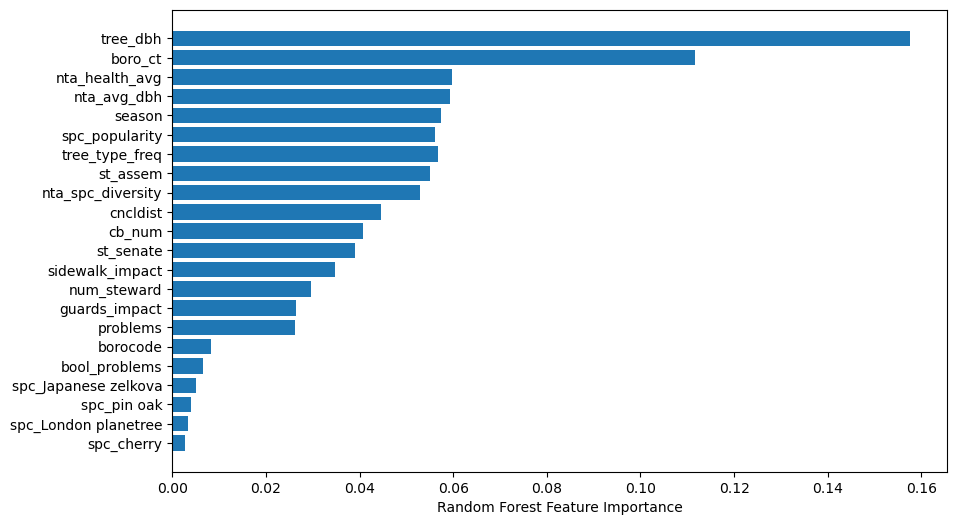

In [60]:
import matplotlib.pyplot as plt

# 特徴量重要度を取得
feature_importances = model.feature_importances_

# 特徴量の名前を取得
feature_names = x_train.columns

# 特徴量の重要度を降順にソート
sorted_idx = feature_importances.argsort()

# 特徴量の重要度をプロット
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

## SHAP

In [61]:
# !pip install shap

In [ ]:
# import shap

# # SHAP値を計算するためのExplainerを作成
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(x_valid)

In [62]:
# # SHAP値をプロット（最初の10個のデータポイントに対するSHAP値）
# shap.summary_plot(shap_values, x_valid, plot_type="bar", show=False)
# plt.show()

# # 全データに対するSHAP値の要約プロット
# shap.summary_plot(shap_values[1], x_valid)


## 提出データ保存

In [63]:
sample_submit = pd.read_csv('../data/sample_submission.csv', index_col=0, header=None) # 応募用サンプルファイル
sample_submit[1] = pred
sample_submit.to_csv('../submit/submit4.csv', header=None)